# Stroke Models & Analysis

In [1]:
#Import DataFrame from Data-Cleaning-Notebook
import pickle
import pandas as pd
import numpy as np
infile = open('pickled_files/df.pickle','rb')
df = pickle.load(infile)
infile.close()


In [2]:
from sklearn.metrics import classification_report, plot_confusion_matrix

In [3]:
def evaluation_report(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    plot_confusion_matrix(model, X, y, cmap='GnBu')

In [4]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi_cat
0,Male,67.0,0,1,Yes,Private,Urban,228.69,formerly smoked,1,obese
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,never smoked,1,unknown
2,Male,80.0,0,1,Yes,Private,Rural,105.92,never smoked,1,obese
3,Female,49.0,0,0,Yes,Private,Urban,171.23,smokes,1,obese
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,normal


In [5]:
from sklearn.model_selection import train_test_split
X = df.drop(['stroke'], axis = 1)
y = df.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Model 1 - First Simple Model

Do a dummy classifier for our first simple model to compare our future models to.

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# setting up testing and training sets

In [7]:
df.stroke.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [8]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

In [9]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred))

Test Accuracy score:  0.9374021909233177


In [10]:
# checking recall
print('Test Recall score: ', recall_score(y_test, dummy_pred))

Test Recall score:  0.0


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


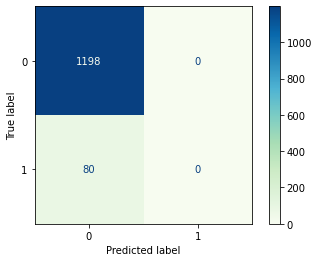

In [11]:
evaluation_report(dummy, X_test, y_test)

#### Model 2 - Logistic Regression: No Penalty / Without Oversampling

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3831 entries, 4000 to 860
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3831 non-null   object 
 1   age                3831 non-null   float64
 2   hypertension       3831 non-null   int64  
 3   heart_disease      3831 non-null   int64  
 4   ever_married       3831 non-null   object 
 5   work_type          3831 non-null   object 
 6   Residence_type     3831 non-null   object 
 7   avg_glucose_level  3831 non-null   float64
 8   smoking_status     3831 non-null   object 
 9   bmi_cat            3831 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 329.2+ KB


In [14]:
X_train_nums = X_train.select_dtypes(['float64'])
X_train_cat = X_train.select_dtypes(exclude = ['float64'])

In [15]:
from sklearn.compose import ColumnTransformer

In [16]:
numerical_pipeline = Pipeline(steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = Pipeline(steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False))
                            ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

log_reg_no_pen_pipe = Pipeline(steps=[
    ('trans', trans),
    ('lr', LogisticRegression(penalty = 'none', max_iter = 1000))
])

In [17]:
log_reg_no_pen_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('lr', LogisticRegression(max_iter=1000, penalty='none'))])

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.20      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.57      0.50      0.49      1278
weighted avg       0.89      0.94      0.91      1278



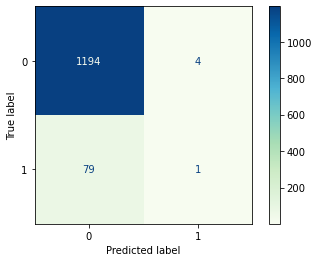

In [18]:
evaluation_report(log_reg_no_pen_pipe, X_test, y_test)

YIKES

#### Model 3 - Over sample then Logistic Regression

In [19]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [20]:
numerical_pipeline = imbpipeline(steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = imbpipeline(steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False))
                            ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [21]:
log_reg_scaled_pipe = imbpipeline(steps=[
    ('trans', trans),
    ('sm', SMOTE()),
    ('lr', LogisticRegression(max_iter = 10000))
])

In [22]:
log_reg_scaled_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('sm', SMOTE()), ('lr', LogisticRegression(max_iter=10000))])

In [23]:
log_reg_scaled_pipe.score(X_train, y_train)

0.7663795353693552

In [24]:
recall_score(y_test, log_reg_scaled_pipe.predict(X_test))

0.725

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1198
           1       0.16      0.72      0.27        80

    accuracy                           0.75      1278
   macro avg       0.57      0.74      0.56      1278
weighted avg       0.93      0.75      0.81      1278



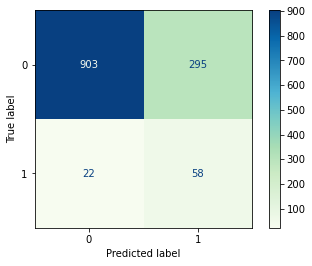

In [25]:
evaluation_report(log_reg_scaled_pipe, X_test, y_test)

#### Model 4 - Logistic Regression with Polynomial Features

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
from sklearn.feature_selection import SelectKBest

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1198
           1       0.18      0.41      0.25        80

    accuracy                           0.84      1278
   macro avg       0.57      0.64      0.58      1278
weighted avg       0.91      0.84      0.87      1278



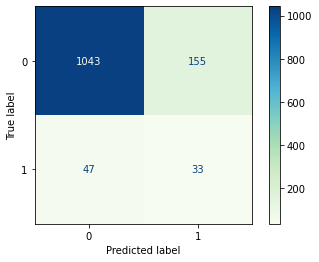

In [28]:
logreg_poly2_pipe = imbpipeline(steps=[
    ('trans', trans),
    ('sm', SMOTE()),
    ('pf', PolynomialFeatures(2, include_bias = False)),
    ('lr', LogisticRegression(max_iter = 10000))
])

logreg_poly2_pipe.fit(X_train, y_train)
evaluation_report(logreg_poly2_pipe, X_test, y_test)

Alrighty, we didn't want polynomial features anyways

#### Model 5 - Voting Classifier with LogReg/DT/KNN

In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [30]:
vc_pipe = imbpipeline(steps=[
    ('trans', trans),
    ('sm', SMOTE()),
    ('vc',VotingClassifier(
                estimators=[('logreg', LogisticRegression(max_iter = 10000)), ('knneighbors', KNeighborsClassifier()), ('decisiontree', DecisionTreeClassifier())], 
                voting='hard'))
])

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1198
           1       0.20      0.45      0.28        80

    accuracy                           0.85      1278
   macro avg       0.58      0.66      0.60      1278
weighted avg       0.91      0.85      0.88      1278



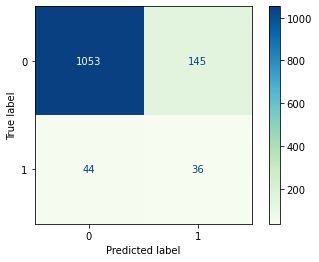

In [31]:
vc_pipe.fit(X_train, y_train)
evaluation_report(vc_pipe, X_test, y_test)

#### Model 6 - GridSearchCV: KNN

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
knn_cv_pipe = imbpipeline(steps=[
    ('trans', trans),
    ('sm', SMOTE()),
    ('clf', KNeighborsClassifier())
])

parameters = {
    'clf__n_neighbors': [10, 20, 50, 75],
    'clf__metric': ['minkowski', 'manhattan'],
    'clf__weights': ['uniform', 'distance'],
}

cv = GridSearchCV(knn_cv_pipe, param_grid=parameters, scoring='recall')
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

In [34]:
cv.best_score_

0.7750445632798574

In [35]:
cv.best_params_

{'clf__metric': 'minkowski', 'clf__n_neighbors': 75, 'clf__weights': 'uniform'}

              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1198
           1       0.14      0.72      0.24        80

    accuracy                           0.71      1278
   macro avg       0.56      0.72      0.53      1278
weighted avg       0.92      0.71      0.79      1278



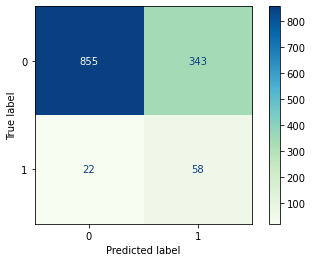

In [36]:
evaluation_report(cv, X_test, y_test)